In [ ]:
!rm -rf spark-3.1.1-bin-hadoop3.2

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
!ls

model_results.pdf  sample_data


In [ ]:
!pip show pyspark

Name: pyspark
Version: 3.5.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 


In [ ]:
!python -V

Python 3.10.12


In [ ]:
!curl -L -o "/usr/local/lib/python3.10/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.3.2-s_2.11.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0   634k      0 --:--:-- --:--:-- --:--:--  635k


In [ ]:
!ls /usr/local/lib/python3.10/dist-packages/pyspark/jars/

activation-1.1.1.jar
aircompressor-0.26.jar
algebra_2.12-2.0.1.jar
annotations-17.0.0.jar
antlr4-runtime-4.9.3.jar
antlr-runtime-3.5.2.jar
aopalliance-repackaged-2.6.1.jar
arpack-3.0.3.jar
arpack_combined_all-0.1.jar
arrow-format-12.0.1.jar
arrow-memory-core-12.0.1.jar
arrow-memory-netty-12.0.1.jar
arrow-vector-12.0.1.jar
audience-annotations-0.5.0.jar
avro-1.11.2.jar
avro-ipc-1.11.2.jar
avro-mapred-1.11.2.jar
blas-3.0.3.jar
bonecp-0.8.0.RELEASE.jar
breeze_2.12-2.1.0.jar
breeze-macros_2.12-2.1.0.jar
cats-kernel_2.12-2.1.1.jar
chill_2.12-0.10.0.jar
chill-java-0.10.0.jar
commons-cli-1.5.0.jar
commons-codec-1.16.0.jar
commons-collections-3.2.2.jar
commons-collections4-4.4.jar
commons-compiler-3.1.9.jar
commons-compress-1.23.0.jar
commons-crypto-1.1.0.jar
commons-dbcp-1.4.jar
commons-io-2.13.0.jar
commons-lang-2.6.jar
commons-lang3-3.12.0.jar
commons-logging-1.1.3.jar
commons-math3-3.6.1.jar
commons-pool-1.5.4.jar
commons-text-1.10.0.jar
compress-lzf-1.1.2.jar
curator-client-2.13.0.jar
cur

In [ ]:
!pip install yfinance

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.param import Param, Params
from pyspark.sql.functions import udf, col, array, avg, lag, year, month
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, DoubleType
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter

In [ ]:
spark = SparkSession.builder \
    .config("spark.jars", "/usr/local/lib/python3.10/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.3.2-s_2.11.jar") \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# DATASET IMPORT

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("NKE Stock Prediction using LSTM") \
    .getOrCreate()

# Fetch NKE stock data from yfinance
nke_data = yf.download("NKE", start="2022-01-01", end="2024-01-01")

nke_df = spark.createDataFrame(nke_data.reset_index())

nke_df.show()

[*********************100%%**********************]  1 of 1 completed


+-------------------+------------------+------------------+------------------+------------------+------------------+--------+
|               Date|              Open|              High|               Low|             Close|         Adj Close|  Volume|
+-------------------+------------------+------------------+------------------+------------------+------------------+--------+
|2022-01-03 00:00:00|167.52999877929688|167.91000366210938|163.30999755859375| 164.6699981689453|160.26797485351562| 5670500|
|2022-01-04 00:00:00| 165.8800048828125|167.17999267578125|             165.0|166.38999938964844| 161.9419708251953| 6064200|
|2022-01-05 00:00:00|166.49000549316406|167.00999450683594|162.10000610351562|            162.25|157.91268920898438| 5021000|
|2022-01-06 00:00:00|162.08999633789062|163.19000244140625|159.05999755859375| 161.0399932861328| 156.7350311279297| 4144600|
|2022-01-07 00:00:00|160.77000427246094|161.13999938964844|156.86000061035156|156.97000122070312| 152.7738037109375| 5

# DATA ANALYSIS

## Data Preprocessing

In this section, we perform data preprocessing steps to prepare the NKE stock data for time series prediction using the GBTRegressor model.

### Steps:

1. **Splitting the Data:**
   - We use PySpark's `randomSplit` function to divide the data, assuming testing data starts from 2023.
   
2. **Selecting Relevant Columns:**
   - We select "Date" and "Close" columns from both training and testing datasets using `select`.

3. **Feature Scaling:**
   - To normalize the "Close" values between 0 and 1, we use `VectorAssembler` to create a vector column "Features" and `MinMaxScaler` to scale this column, resulting in "Scaled_Features".

4. **Creating Lagged Features:**
   - Using the `lag` function in PySpark, we create lagged features like "lag_1" to "lag_10" to capture temporal dependencies, ordering the data by "Date".

5. **Handling Missing Values:**
   - We remove rows with missing values using `na.drop()` to ensure data completeness.

6. **Preparing Test Data:**
   - For prediction, we prepare the test data by selecting the "Date" column, combining "Scaled_Features" with lagged features into an array column "Features", and renaming "Close" as "Label".


In [ ]:
data_splits = nke_df.randomSplit([0.8, 0.2])

train_data, test_data = data_splits

# Preprocessing training data
train_data_selected = train_data.select("Date", "Close")
# Define column parameters separately
assembler_params = {"inputCols": ["Close"], "outputCol": "Features"}
scaler_params = {"inputCol": "Features", "outputCol": "Scaled_Features"}

# Initialize VectorAssembler with parameters
vector_assembler = VectorAssembler()
vector_assembler.setInputCols(assembler_params["inputCols"])
vector_assembler.setOutputCol(assembler_params["outputCol"])

# Initialize MinMaxScaler with parameters
scaler = MinMaxScaler()
scaler.setInputCol(scaler_params["inputCol"])
scaler.setOutputCol(scaler_params["outputCol"])

# Build the pipeline with the stages prepared
pipeline = Pipeline(stages=[vector_assembler, scaler])

scaler_model_fitted = pipeline.fit(train_data_selected)

normalized_train_data = scaler_model_fitted.transform(train_data_selected)

test_data_for_scaling = test_data.select("Date", "Close")

normalized_test_data = scaler_model_fitted.transform(test_data_for_scaling)


# perform transform on test
scaled_test_data = scaler_model_fitted.transform(test_data.select("Date", "Close"))

# Creating a window specification
windowSpec = Window.orderBy("Date")

# Function to create data with time steps using window functions
def create_lagged_features(df, lag_count=10):
    for i in range(1, lag_count + 1):
        df = df.withColumn(f"lag_{i}", lag(df["Scaled_Features"], i).over(windowSpec))
    return df

# Creating lagged features for training data
lagged_train_data = create_lagged_features(normalized_train_data)
lagged_train_data = lagged_train_data.na.drop()

# Creating lagged features for testing data
lagged_test_data = create_lagged_features(scaled_test_data)
lagged_test_data = lagged_test_data.na.drop()

test_data = lagged_test_data.select(col("Date"), array(col("Scaled_Features"), *[col(f"lag_{i}") for i in range(1, 11)]).alias("Features"), col("Close").alias("Label"))

## LSTM Class Definition

This section outlines the definition of the `LSTMModel` class, which encapsulates the functionality of the Long Short-Term Memory (LSTM) model within the PySpark ML library framework. The class is designed to facilitate parameter management and hyperparameter tuning.

### Key Methods and MapReduce Operations

#### Map Operations

- **map_gradient**:
  - **Purpose**: Calculates gradients for each training data row.
  - **Usage**: Called within the `train` method via `map` transformation on the RDD of training data, enabling distributed computation of gradients.
  
- **map_predict_train**:
  - **Purpose**: (Hypothetical use) Makes predictions on training data.
  - **Details**: Takes a row, predicts using current weights, and returns the date, predicted value, and actual label. Useful for validation during training.
  
- **predict**:
  - **Purpose**: Makes predictions on the test data.
  - **Usage**: Invoked within the `evaluate` method using `map` transformation on the RDD of test data, facilitating distributed predictions.

#### Reduce Operations

- **reduce_gradient**:
  - **Purpose**: Aggregates gradients from multiple map operations.
  - **Usage**: Utilized within the `train` method via the `reduce` action to sum gradients across all partitions, essential for updating model weights globally.

### Training and Evaluation

- **train**:
  - **Process**:
    1. Initiates with the `map_gradient` function to compute gradients.
    2. Aggregates gradients using `reduce_gradient`.
    3. Updates weights with the aggregated gradients across epochs.
  - **Implementation**: Employs MapReduce by mapping gradient calculations and reducing them across the cluster.

- **evaluate**:
  - **Process**:
    1. Executes predictions on test data via the `predict` method.
    2. Computes evaluation metrics (MSE, MAE, RMSE, R2) from predictions.
  - **Details**: Uses the `map` transformation for distributed prediction and gathers results to assess model performance.



In [ ]:
class LSTMModel(Params):
    in_dim = Param(Params._dummy(), "in_dim", "Input dimension of the LSTM cell")
    hidden_dim = Param(Params._dummy(), "hidden_dim", "Hidden dimension of the LSTM cell")
    learn_rate = Param(Params._dummy(), "learn_rate", "Learning rate")
    num_epochs = Param(Params._dummy(), "num_epochs", "Number of epochs")

    def __init__(self, in_dim=None, hidden_dim=None, out_dim=None, learn_rate=None, num_epochs=None):
        super(LSTMModel, self).__init__()
        self._setDefault(in_dim=10, hidden_dim=128, learn_rate=0.001, num_epochs=100)
        self.out_dim = out_dim
        self.lstm_weights = None
        self.lstm_weights_broadcast = None

        if in_dim is not None:
            self._set(in_dim=in_dim)
        if hidden_dim is not None:
            self._set(hidden_dim=hidden_dim)
        if learn_rate is not None:
            self._set(learn_rate=learn_rate)
        if num_epochs is not None:
            self._set(num_epochs=num_epochs)

    def initialize_lstm_weights(self):
        hidden_units = self.getOrDefault(self.hidden_dim)
        input_units = self.getOrDefault(self.in_dim)
        output_units = self.out_dim

        def generate_weights(rows, cols):
            return np.random.normal(size=(rows, cols))

        def generate_biases(size):
            return np.zeros(shape=(size, 1))

        input_weights = generate_weights(hidden_units, input_units + hidden_units)
        input_bias = generate_biases(hidden_units)

        forget_weights = generate_weights(hidden_units, input_units + hidden_units)
        forget_bias = generate_biases(hidden_units)

        output_weights = generate_weights(hidden_units, input_units + hidden_units)
        output_bias = generate_biases(hidden_units)

        cell_weights = generate_weights(hidden_units, input_units + hidden_units)
        cell_bias = generate_biases(hidden_units)

        output_layer_weights = generate_weights(output_units, hidden_units)
        output_layer_bias = generate_biases(output_units)

        return input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias

    def lstm_forward(self, xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias):
        concat = np.vstack((ht_prev, xt))

        it = self.activation_sigmoid(np.dot(input_weights, concat) + input_bias)
        ft = self.activation_sigmoid(np.dot(forget_weights, concat) + forget_bias)
        ot = self.activation_sigmoid(np.dot(output_weights, concat) + output_bias)

        ct_tilde = np.tanh(np.dot(cell_weights, concat) + cell_bias)
        ct = ft * ct_prev + it * ct_tilde
        ht = ot * np.tanh(ct)

        return ht, ct, it, ft, ot, ct_tilde

    def lstm_backward(self, dht, dct, xt, ht, ct, ht_prev, ct_prev, it, ft, ot, ct_tilde, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias):
        concat = np.vstack((ht_prev, xt))

        dot = dht * np.tanh(ct) * self.activation_sigmoid_derivative(ot)
        d_output_weights = np.dot(dot, concat.T)
        d_output_bias = dot

        dct += dht * ot * self.activation_tanh_derivative(np.tanh(ct))

        dft = dct * ct_prev * self.activation_sigmoid_derivative(ft)
        d_forget_weights = np.dot(dft, concat.T)
        d_forget_bias = dft

        dit = dct * ct_tilde * self.activation_sigmoid_derivative(it)
        d_input_weights = np.dot(dit, concat.T)
        d_input_bias = dit

        dct_tilde = dct * it * self.activation_tanh_derivative(ct_tilde)
        d_cell_weights = np.dot(dct_tilde, concat.T)
        d_cell_bias = dct_tilde

        dct_prev = dct * ft

        dht_prev = np.dot(input_weights.T, dit) + np.dot(forget_weights.T, dft) + np.dot(output_weights.T, dot) + np.dot(cell_weights.T, dct_tilde)
        dht_prev = dht_prev[:self.getOrDefault(self.hidden_dim), :]
        dct_prev = dct * ft

        return d_input_weights, d_input_bias, d_forget_weights, d_forget_bias, d_output_weights, d_output_bias, d_cell_weights, d_cell_bias, dht_prev.reshape(-1, 1), dct_prev.reshape(-1, 1)

    def activation_sigmoid(self, input_value):
        exp_value = np.exp(-input_value)
        return np.divide(1, np.add(1, exp_value))

    def activation_sigmoid_derivative(self, sigmoid_output):
        return np.multiply(sigmoid_output, np.subtract(1, sigmoid_output))

    def activation_tanh(self, input_value):
        return np.tanh(input_value)

    def activation_tanh_derivative(self, tanh_output):
        return np.subtract(1, np.square(tanh_output))

    def map_gradient(self, row, lstm_weights):
        xt = np.array(row[4:], dtype=np.float32).reshape(self.getOrDefault(self.in_dim), 1)
        yt = np.array([row[1]], dtype=np.float32).reshape(self.out_dim, 1)

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = lstm_weights

        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        ht, ct, it, ft, ot, ct_tilde = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        dout = output - yt
        d_output_layer_weights = np.dot(dout, ht.T)
        d_output_layer_bias = dout
        dht = np.dot(output_layer_weights.T, dout)
        dct = np.zeros_like(ct)

        d_input_weights, d_input_bias, d_forget_weights, d_forget_bias, d_output_weights, d_output_bias, d_cell_weights, d_cell_bias, dht_prev, dct_prev = self.lstm_backward(dht, dct, xt, ht, ct, ht_prev, ct_prev, it, ft, ot, ct_tilde, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)

        return [(d_input_weights, d_input_bias), (d_forget_weights, d_forget_bias), (d_output_weights, d_output_bias), (d_cell_weights, d_cell_bias), (d_output_layer_weights, d_output_layer_bias)]

    def _update_weights(self, gradients):
        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = self.lstm_weights

        d_input_weights, d_input_bias = gradients[0]
        d_forget_weights, d_forget_bias = gradients[1]
        d_output_weights, d_output_bias = gradients[2]
        d_cell_weights, d_cell_bias = gradients[3]
        d_output_layer_weights, d_output_layer_bias = gradients[4]

        input_weights -= self.getOrDefault(self.learn_rate) * d_input_weights
        input_bias -= self.getOrDefault(self.learn_rate) * d_input_bias
        forget_weights -= self.getOrDefault(self.learn_rate) * d_forget_weights
        forget_bias -= self.getOrDefault(self.learn_rate) * d_forget_bias
        output_weights -= self.getOrDefault(self.learn_rate) * d_output_weights
        output_bias -= self.getOrDefault(self.learn_rate) * d_output_bias
        cell_weights -= self.getOrDefault(self.learn_rate) * d_cell_weights
        cell_bias -= self.getOrDefault(self.learn_rate) * d_cell_bias
        output_layer_weights -= self.getOrDefault(self.learn_rate) * d_output_layer_weights
        output_layer_bias -= self.getOrDefault(self.learn_rate) * d_output_layer_bias

        self.lstm_weights = (input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias)

    def reduce_gradient(self, g1, g2):
        return [(a + c, b + d) for (a, b), (c, d) in zip(g1, g2)]

    def map_predict_train(self, row):
        xt = np.array(row[4:], dtype=np.float32).reshape(self.getOrDefault(self.in_dim), 1)
        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = self.lstm_weights_broadcast.value

        ht, ct, _, _, _, _ = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        return (row[0], float(output[0][0]), row[1])

    def predict(self, row, lstm_weights):
        xt = np.array(row[1][1:], dtype=np.float32).reshape(self.getOrDefault(self.in_dim), 1)
        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = lstm_weights

        ht, ct, _, _, _, _ = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        return (row[0], float(output[0][0]), row[2])

    def train(self, lagged_train_data, lstm_weights):
        self.lstm_weights = lstm_weights

        for epoch in range(self.getOrDefault(self.num_epochs)):
            gradients = lagged_train_data.rdd \
                .map(lambda row: self.map_gradient(row, self.lstm_weights)) \
                .reduce(self.reduce_gradient)

            self._update_weights(gradients)

            print(f"Epoch {epoch+1}/{self.getOrDefault(self.num_epochs)} completed")

    def evaluate(self, test_data):
        predictions = test_data.rdd \
            .map(self.predict) \
            .toDF(["Date", "Prediction", "Actual"])
        predictions.show()

        mse = predictions.selectExpr("mean(power(Prediction - Actual, 2)) as mse").collect()[0]["mse"]
        mae = predictions.selectExpr("mean(abs(Prediction - Actual)) as mae").collect()[0]["mae"]
        rmse = predictions.selectExpr("sqrt(mean(power(Prediction - Actual, 2))) as rmse").collect()[0]["rmse"]
        mean_actual = predictions.selectExpr("avg(Actual) as mean_actual").collect()[0]["mean_actual"]
        r2 = predictions.selectExpr(f"1 - sum(power(Prediction - Actual, 2)) / sum(power(Actual - {mean_actual}, 2)) as r2").collect()[0]["r2"]

        print(f"The MSE is : {mse}")
        print(f"The MAE is : {mae}")
        print(f"The RMSE is: {rmse}")
        print(f"The R2 is : {r2}")

        return predictions

## Helper Functions

In this section, we define several helper functions that are used in the training and evaluation process of the LSTM model. These functions are designed to modularize the code and improve readability. Let's go through each function:

### create_lstm_model
- **Description**: This function takes a parameter map (param_map) as input and creates an instance of the LSTMModel class with the specified hyperparameters.

### evaluate_model
- **Description**: This function evaluates the trained LSTM model on the test data. It takes the trained model, test data, and LSTM weights as input. Inside the function, the predict method of the LSTMModel class is called using the `map` transformation on the RDD of the test data. This allows for distributed prediction on the test data. The predicted values, along with the corresponding dates and actual values, are then collected and returned as a DataFrame.

### calculate_metrics
- **Description**: This function calculates various evaluation metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R2) based on the predicted and actual values.

### save_model_results_to_pdf
- **Description**: This function saves the model results to a PDF file. It takes a DataFrame (df_results) containing the model results as input.

### print_best_hyperparameters
- **Description**: This function prints the best hyperparameters obtained during the hyperparameter tuning process. It takes the best parameters (best_params) as input.

### print_evaluation_metrics
- **Description**: This function prints the evaluation metrics (MSE, MAE, RMSE, R2) for the best model. It takes the calculated metrics as input.

### plot_actual_vs_predicted
- **Description**: This function plots the actual prices versus the predicted prices. It takes the predictions DataFrame as input, collects the actual prices, predicted prices, and corresponding dates, and creates a plot using Matplotlib.


In [ ]:
def create_lstm_model(param_map):
    return LSTMModel(
        in_dim=param_map[LSTMModel.in_dim],
        hidden_dim=param_map[LSTMModel.hidden_dim],
        learn_rate=param_map[LSTMModel.learn_rate],
        num_epochs=param_map[LSTMModel.num_epochs],
        out_dim=1
    )

def evaluate_model(model, test_data, lstm_weights):
    test_data = test_data.select(
        col("Date"),
        array(col("Scaled_Features"), *[col(f"lag_{i}") for i in range(1, 11)]).alias("Features"),
        col("Close").alias("Label")
    )
    return test_data.rdd \
        .map(lambda row: model.predict(row, lstm_weights)) \
        .toDF(["Date", "Prediction", "Actual"])

def calculate_metrics(predictions):
    mse = predictions.selectExpr("mean(power(Prediction - Actual, 2)) as mse").collect()[0]["mse"]
    mae = predictions.selectExpr("mean(abs(Prediction - Actual)) as mae").collect()[0]["mae"]
    rmse = predictions.selectExpr("sqrt(mean(power(Prediction - Actual, 2))) as rmse").collect()[0]["rmse"]
    mean_actual = predictions.select(avg("Actual")).collect()[0][0]
    r2 = predictions.selectExpr(f"1 - sum(power(Prediction - Actual, 2)) / sum(power(Actual - {mean_actual}, 2)) as r2").collect()[0]["r2"]
    return rmse, mse, mae, r2



def save_model_results_to_pdf(df_results):
    df_results.insert(0, "Experiment", range(1, len(df_results) + 1))

    columns = ["Experiment", "Input Size", "Hidden Size", "Learning Rate", "Num Epochs",
               "Train RMSE", "Train MSE", "Train MAE", "Train R-squared",
               "Test RMSE", "Test MSE", "Test MAE", "Test R-squared"]
    df_results = df_results[columns]

    best_model_index = df_results["Test RMSE"].idxmin()
    df_styled = df_results.style.apply(lambda x: 'background-color: yellow' if x.name == best_model_index else '',
                                       axis=1)

    def format_large_numbers(value):
        if isinstance(value, float) and (value > 1e4 or value < 1e-4):
            return f"{value:.2e}"
        return f"{value:.4f}"

    data = []
    for _, row in df_styled.data.iterrows():
        experiment = row["Experiment"]
        parameters = [
            f"Input Size: {row['Input Size']}",
            f"Hidden Size: {row['Hidden Size']}",
            f"Learning Rate: {row['Learning Rate']}",
            f"Num Epochs: {row['Num Epochs']}"
        ]
        metrics = [
            f"Train RMSE: {format_large_numbers(row['Train RMSE'])}",
            f"Train MSE: {format_large_numbers(row['Train MSE'])}",
            f"Train MAE: {format_large_numbers(row['Train MAE'])}",
            f"Train R-squared: {format_large_numbers(row['Train R-squared'])}",
            f"Test RMSE: {format_large_numbers(row['Test RMSE'])}",
            f"Test MSE: {format_large_numbers(row['Test MSE'])}",
            f"Test MAE: {format_large_numbers(row['Test MAE'])}",
            f"Test R-squared: {format_large_numbers(row['Test R-squared'])}"
        ]
        data.append([experiment, "\n".join(parameters), "\n".join(metrics)])

    df_formatted = pd.DataFrame(data, columns=["Experiment", "Parameters", "Metrics"])

    pdf_filename = "model_results.pdf"
    with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(12, len(df_formatted) * 1.2))
        ax.axis('off')

        table = ax.table(cellText=df_formatted.values, colLabels=df_formatted.columns,
                         cellLoc='center', loc='center', colWidths=[0.1, 0.35, 0.55])

        max_lines = df_formatted.applymap(lambda x: len(str(x).split('\n'))).max().max()
        row_height = 0.1 * max_lines

        for (row, col), cell in table.get_celld().items():
            if (row > 0):
                cell.set_height(row_height)

        table.auto_set_font_size(False)
        table.set_fontsize(8)

        pdf.savefig(fig, bbox_inches='tight')

    print("Model results saved as", pdf_filename)


def print_best_hyperparameters(best_params):
    for param, value in best_params.items():
        print(f"{param.name}: {value}")

def print_evaluation_metrics(mse, mae, rmse, r2):
    print(f"The MSE is : {mse}")
    print(f"The MAE is : {mae}")
    print(f"The RMSE is: {rmse}")
    print(f"The R2 is : {r2}")

def plot_actual_vs_predicted(predictions):
    actual_prices = [row["Actual"] for row in predictions.collect()]
    predicted_prices = [row["Prediction"] for row in predictions.collect()]
    dates = [row["Date"] for row in predictions.collect()]

    fig, ax = plt.subplots(figsize=(12, 8))

    from matplotlib.dates import DateFormatter

    # Plotting actual and predicted prices
    ax.plot(dates, actual_prices, color='dodgerblue', linestyle='-', label='Actual NKE Stock Prices')
    ax.plot(dates, predicted_prices, color='coral', linestyle='--', label='Predicted NKE Stock Prices')

    # Setting labels and title with font adjustments
    ax.set_xlabel("Stock Date", fontsize=12, color='gray')
    ax.set_ylabel("NKE Stock Price", fontsize=12, color='gray')
    ax.set_title("Comparison of Actual vs. Predicted NKE Stock Prices", fontsize=14, fontweight='bold')

    # Formatting the date axis
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    ax.legend(loc='upper left')
    ax.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


## Training and Evaluation

The `train_and_evaluate` function is designed to perform the training and evaluation of the LSTM model, incorporating hyperparameter tuning for optimization. Below are the key aspects of this process:

### Key Aspects

- **Regression Evaluation**:
  - Utilizes `RegressionEvaluator` from the PySpark ML library to assess model performance using the RMSE metric.

- **Hyperparameter Tuning**:
  - Defines a parameter grid (`param_grid`) using `ParamGridBuilder` to outline the search space for hyperparameters.

- **Model Training**:
  - Iterates over combinations of hyperparameters.
  - For each combination, creates and trains an LSTM model using the `create_lstm_model` and `train` methods.

- **Model Evaluation**:
  - Evaluates each trained model on test data using the `evaluate_model` function, which applies the `predict` method of the `LSTMModel` class to each row. This method uses a map transformation for distributed prediction across the cluster.

- **Metric Calculation**:
  - Calculates evaluation metrics such as RMSE, MSE, MAE, and R-squared using the `calculate_metrics` function.

- **Tracking Best Model**:
  - Maintains records of the best hyperparameters and corresponding RMSE values for optimal model selection.

- **Results Documentation**:
  - Saves model evaluation results to a PDF using the `save_model_results_to_pdf` function.

- **Final Model Training and Evaluation**:
  - Trains and evaluates the best model configuration on the entire set of lagged training and test data.

- **Visualization**:
  - Plots actual versus predicted prices using the `plot_actual_vs_predicted` function to visually assess the model's performance.

### Implementation Overview

This comprehensive approach ensures a thorough exploration of the hyperparameter space, rigorous training, and meticulous evaluation, culminating in a well-documented and visually represented outcome of the model's predictive capabilities.


In [ ]:
import io
from google.colab import files



def train_and_evaluate(lagged_train_data, lagged_test_data, param_grid):
    evaluator = RegressionEvaluator(labelCol="Actual", predictionCol="Prediction", metricName="rmse")
    best_params = None
    best_rmse = float("inf")
    results = []

    for param_map in param_grid:
        lstm_model = create_lstm_model(param_map)
        lstm_weights = lstm_model.initialize_lstm_weights()
        lstm_model.train(lagged_train_data, lstm_weights)

        # Evaluate on training data
        train_predictions = evaluate_model(lstm_model, lagged_train_data, lstm_weights)
        train_rmse, train_mse, train_mae, train_r2 = calculate_metrics(train_predictions)

        # Evaluate on testing data
        test_predictions = evaluate_model(lstm_model, lagged_test_data, lstm_weights)
        test_rmse, test_mse, test_mae, test_r2 = calculate_metrics(test_predictions)

        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_params = param_map

        results.append({
            "Input Size": param_map[LSTMModel.in_dim],
            "Hidden Size": param_map[LSTMModel.hidden_dim],
            "Learning Rate": param_map[LSTMModel.learn_rate],
            "Num Epochs": param_map[LSTMModel.num_epochs],
            "Train RMSE": train_rmse,
            "Train MSE": train_mse,
            "Train MAE": train_mae,
            "Train R-squared": train_r2,
            "Test RMSE": test_rmse,
            "Test MSE": test_mse,
            "Test MAE": test_mae,
            "Test R-squared": test_r2
        })
    df_results = pd.DataFrame(results)
    save_model_results_to_pdf(df_results)

    print("Best hyperparameters:")
    print_best_hyperparameters(best_params)

    best_model = create_lstm_model(best_params)
    best_lstm_weights = best_model.initialize_lstm_weights()
    best_model.train(lagged_train_data, best_lstm_weights)

    train_predictions = evaluate_model(best_model, lagged_train_data, best_lstm_weights)
    test_predictions = evaluate_model(best_model, lagged_test_data, best_lstm_weights)

    train_mse, train_mae, train_rmse, train_r2 = calculate_metrics(train_predictions)
    test_mse, test_mae, test_rmse, test_r2 = calculate_metrics(test_predictions)

    print("Training metrics:")
    print_evaluation_metrics(train_mse, train_mae, train_rmse, train_r2)

    print("Testing metrics:")
    print_evaluation_metrics(test_mse, test_mae, test_rmse, test_r2)
    plot_actual_vs_predicted(test_predictions)

    return test_predictions

# Training and Evaluation Execution

Epoch 1/100 completed
Epoch 2/100 completed
Epoch 3/100 completed
Epoch 4/100 completed
Epoch 5/100 completed
Epoch 6/100 completed
Epoch 7/100 completed
Epoch 8/100 completed
Epoch 9/100 completed
Epoch 10/100 completed
Epoch 11/100 completed
Epoch 12/100 completed
Epoch 13/100 completed
Epoch 14/100 completed
Epoch 15/100 completed
Epoch 16/100 completed
Epoch 17/100 completed
Epoch 18/100 completed
Epoch 19/100 completed
Epoch 20/100 completed
Epoch 21/100 completed
Epoch 22/100 completed
Epoch 23/100 completed
Epoch 24/100 completed
Epoch 25/100 completed
Epoch 26/100 completed
Epoch 27/100 completed
Epoch 28/100 completed
Epoch 29/100 completed
Epoch 30/100 completed
Epoch 31/100 completed
Epoch 32/100 completed
Epoch 33/100 completed
Epoch 34/100 completed
Epoch 35/100 completed
Epoch 36/100 completed
Epoch 37/100 completed
Epoch 38/100 completed
Epoch 39/100 completed
Epoch 40/100 completed
Epoch 41/100 completed
Epoch 42/100 completed
Epoch 43/100 completed
Epoch 44/100 complet

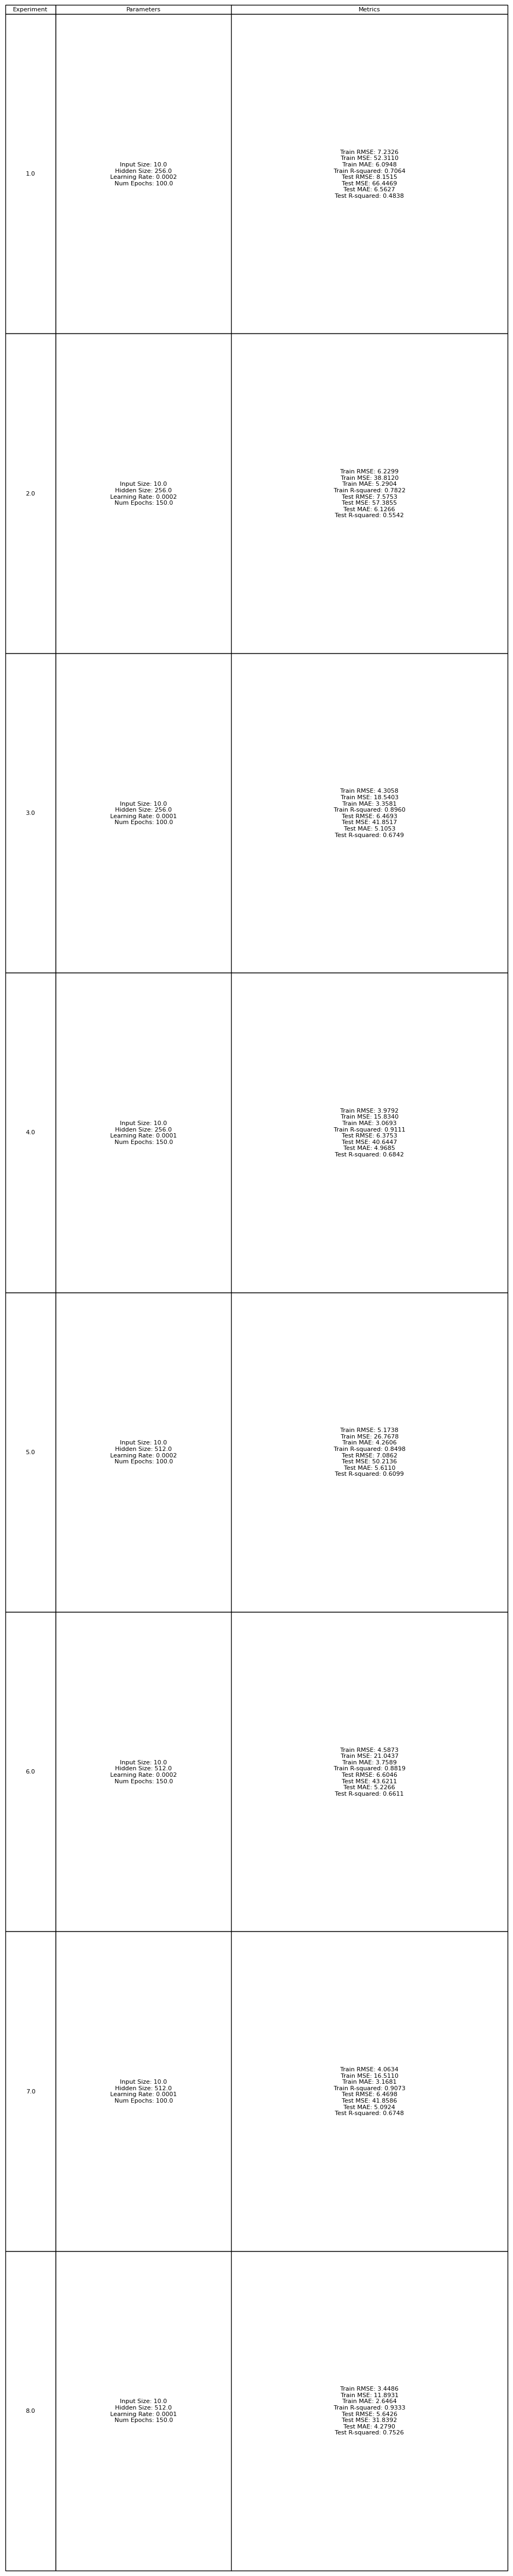

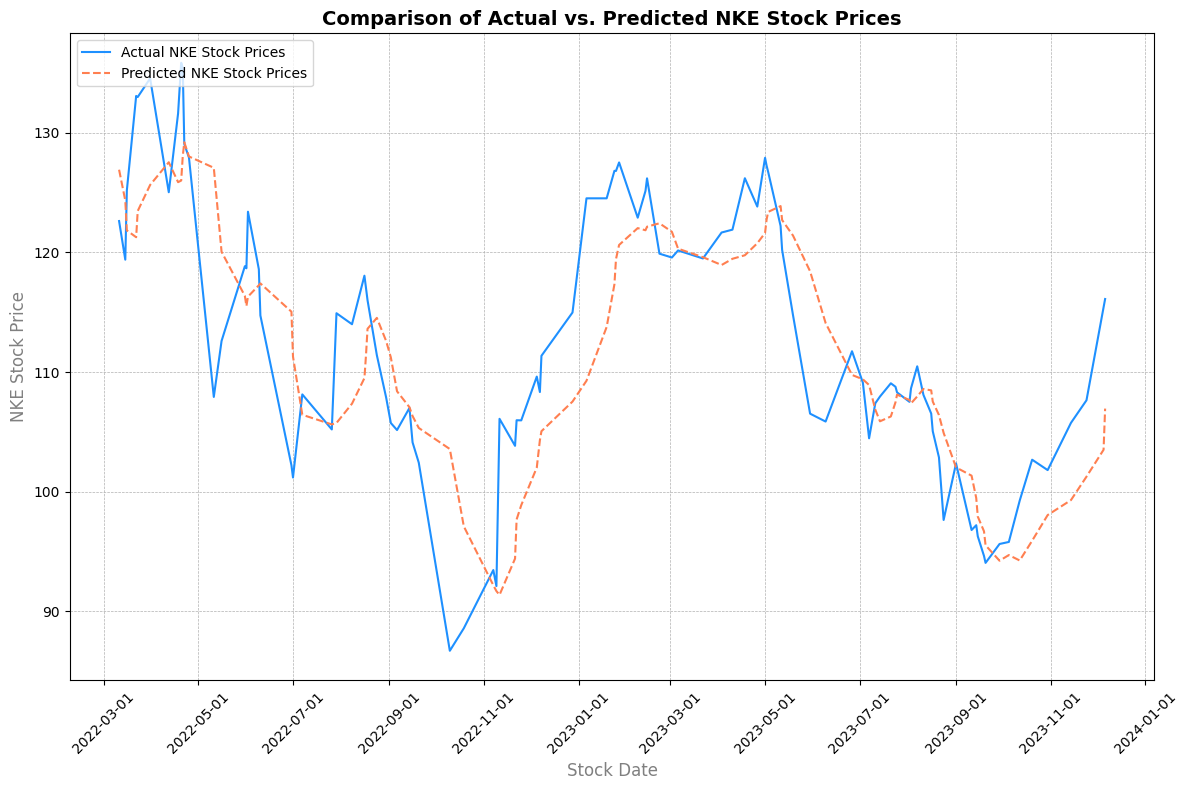

Date,Prediction,Actual
2022-03-11 00:00:00,126.9229902716821,122.62999725341797
2022-03-15 00:00:00,124.34427375353336,119.4000015258789
2022-03-16 00:00:00,121.84776090018966,125.19000244140625
2022-03-22 00:00:00,121.27755924125024,133.08999633789062
2022-03-23 00:00:00,123.46764491755788,133.0
2022-03-31 00:00:00,125.6490231487813,134.55999755859375
2022-04-12 00:00:00,127.54754928966592,125.04000091552734
2022-04-18 00:00:00,125.88062033889658,131.6300048828125
2022-04-20 00:00:00,126.0166867543757,135.8699951171875
2022-04-21 00:00:00,128.04456839242965,135.4600067138672


In [ ]:
test_data = lagged_test_data.select(col("Date"), array(col("Scaled_Features"), *[col(f"lag_{i}") for i in range(1, 11)]).alias("Features"), col("Close").alias("Label"))

# hyperparameter matrix definitions
param_grid = ParamGridBuilder() \
    .addGrid(LSTMModel.in_dim, [10]) \
    .addGrid(LSTMModel.hidden_dim, [256,512]) \
    .addGrid(LSTMModel.learn_rate, [0.0002,0.0001]) \
    .addGrid(LSTMModel.num_epochs, [100,150]) \
    .build()

# Train and evaluate the model with different hyperparameters
train_and_evaluate(lagged_train_data, lagged_test_data, param_grid)

# MODEL PERFORMANCE COMPARISON: GBT CLASSIFIER

Training RMSE: 0.7722
Testing RMSE: 0.6600
Training R-squared: 0.9967
Testing R-squared: 0.9966


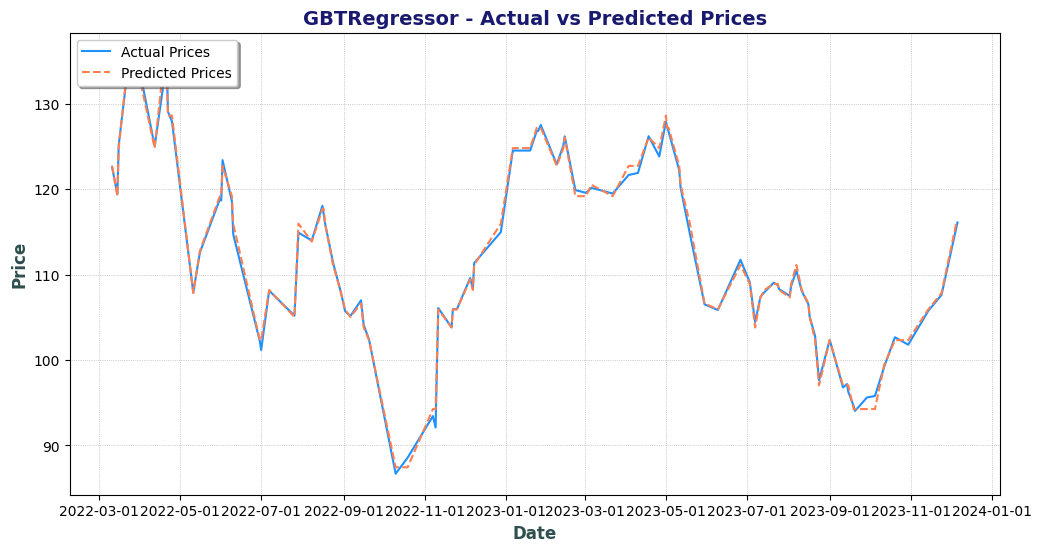

In [ ]:



# Prepare training data
input_features = ["Scaled_Features"] + [f"lag_{i}" for i in range(1, 11)]

assembler = VectorAssembler(inputCols=input_features, outputCol="Assembled_Features")

assembled_train_data = assembler.transform(lagged_train_data)

train_data = assembled_train_data.select(
    col("Date"),
    col("Features"),
    col("Close").alias("Label")
)

assembled_test_data = assembler.transform(lagged_test_data)

test_data = assembled_test_data.select(
    col("Date"),
    col("Features"),
    col("Close").alias("Label")
)

# Create and train GBTRegressor model
gbt_model = GBTRegressor(featuresCol="Features", labelCol="Label", maxIter=100, maxDepth=5, subsamplingRate=0.8).fit(train_data)

# Predictions
predictions_test = gbt_model.transform(test_data)
predictions_train = gbt_model.transform(train_data)

common_params = {"labelCol": "Label", "predictionCol": "prediction"}

rmse_params = {**common_params, "metricName": "rmse"}
rmse_evaluator = RegressionEvaluator(**rmse_params)

# Extend the common parameters dictionary for R2 evaluator specific settings
r2_params = {**common_params, "metricName": "r2"}
r2_evaluator = RegressionEvaluator(**r2_params)

rmse_train = rmse_evaluator.evaluate(predictions_train)
rmse_test = rmse_evaluator.evaluate(predictions_test)
r2_train = r2_evaluator.evaluate(predictions_train)
r2_test = r2_evaluator.evaluate(predictions_test)

# Define the metrics in a dictionary for more dynamic access
metrics = {
    "Training RMSE": rmse_train,
    "Testing RMSE": rmse_test,
    "Training R-squared": r2_train,
    "Testing R-squared": r2_test
}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

actual = [row["Label"] for row in predictions_test.collect()]
predicted = [row["prediction"] for row in predictions_test.collect()]
dates = [row["Date"] for row in predictions_test.collect()]


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dates, actual, color='dodgerblue', linestyle='-', label='Actual Prices')
ax.plot(dates, predicted, color='coral', linestyle='--', label='Predicted Prices')

ax.set_xlabel("Date", fontsize=12, fontweight='bold', color='darkslategray')
ax.set_ylabel("Price", fontsize=12, fontweight='bold', color='darkslategray')
ax.set_title("GBTRegressor - Actual vs Predicted Prices", fontsize=14, fontweight='bold', color='midnightblue')

ax.legend(loc='upper left', shadow=True)

ax.grid(True, linestyle=':', color='gray', linewidth=0.5, alpha=0.7)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))



plt.show()

